In [4]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 955.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=13cdd5054d0c967ff63ebcc33b6c2c7549e9df42f5e0d9649918ffacae3ca589
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [1]:
!pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 3.2 MB/s eta 0:00:00


In [22]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [6]:
if not (os.path.isfile('Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

#if not (os.path.isfile('/content/Salinas_corrected.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
#if not (os.path.isfile('/content/Salinas_gt.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat

--2023-12-23 05:00:46--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2023-12-23 05:00:46--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  2.18MB/s    in 2.6s    

2023-12-23 05:00:49 (2.18 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2023-12-23 05:00:49--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.e

# Data Loading

In [7]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [8]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']

    return data, labels

In [9]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [10]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [11]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [12]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [13]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [15]:
K = X.shape[2]

In [16]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [17]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [18]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [24]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [25]:
ytrain = keras.utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [26]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [27]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [28]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        331840    
                                                                 
 flatten (Flatten)           (None, 18496)             0     

In [31]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [34]:
# compiling the model
#adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [35]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [36]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 2.9845 - accuracy: 0.1252

13/13 [==============================] - 15s 241ms/step - loss: 2.9845 - accuracy: 0.1252
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 2.6978 - accuracy: 0.1234

13/13 [==============================] - 2s 191ms/step - loss: 2.6980 - accuracy: 0.1233
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 2.5450 - accuracy: 0.1520

13/13 [==============================] - 3s 193ms/step - loss: 2.5448 - accuracy: 0.1519
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 2.4777 - accuracy: 0.1862

13/13 [==============================] - 2s 190ms/step - loss: 2.4778 - accuracy: 0.1861
Epoch 5/100
12/13 [==========================>...] - ETA: 0s - loss: 2.4223 - accuracy: 0.1995

13/13 [==============================] - 2s 191ms/step - loss: 2.4229 - accuracy: 0.1994
Epoch 6/100
12/13 [==========================>...] - ETA: 0s - loss: 2.3832 - accuracy: 0.2301

13/13 [==============================] - 3s 192ms/step - loss: 2.3835 - accuracy: 0.2300
Epoch 7/100
12/13 [==========================>...] - ETA: 0s - loss: 2.1897 - accuracy: 0.2318

13/13 [==============================] - 3s 193ms/step - loss: 2.1897 - accuracy: 0.2316
Epoch 8/100
12/13 [==========================>...] - ETA: 0s - loss: 1.9021 - accuracy: 0.3337

13/13 [==============================] - 3s 197ms/step - loss: 1.9020 - accuracy: 0.3334
Epoch 9/100
12/13 [==========================>...] - ETA: 0s - loss: 1.5994 - accuracy: 0.4329

13/13 [==============================] - 3s 194ms/step - loss: 1.5994 - accuracy: 0.4327
Epoch 10/100
12/13 [==========================>...] - ETA: 0s - loss: 1.3438 - accuracy: 0.5365

13/13 [==============================] - 3s 195ms/step - loss: 1.3434 - accuracy: 0.5364
Epoch 11/100
12/13 [==========================>...] - ETA: 0s - loss: 1.1240 - accuracy: 0.6214

13/13 [==============================] - 3s 197ms/step - loss: 1.1250 - accuracy: 0.6210
Epoch 12/100
12/13 [==========================>...] - ETA: 0s - loss: 0.8223 - accuracy: 0.7321

13/13 [==============================] - 3s 197ms/step - loss: 0.8222 - accuracy: 0.7323
Epoch 13/100
12/13 [==========================>...] - ETA: 0s - loss: 0.5984 - accuracy: 0.8076

13/13 [==============================] - 3s 203ms/step - loss: 0.5983 - accuracy: 0.8074
Epoch 14/100
12/13 [==========================>...] - ETA: 0s - loss: 0.5550 - accuracy: 0.8151

13/13 [==============================] - 3s 200ms/step - loss: 0.5551 - accuracy: 0.8152
Epoch 15/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3494 - accuracy: 0.8952

13/13 [==============================] - 3s 200ms/step - loss: 0.3492 - accuracy: 0.8953
Epoch 16/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2393 - accuracy: 0.9277

13/13 [==============================] - 3s 200ms/step - loss: 0.2400 - accuracy: 0.9275
Epoch 17/100
12/13 [==========================>...] - ETA: 0s - loss: 0.4429 - accuracy: 0.8558

13/13 [==============================] - 3s 200ms/step - loss: 0.4429 - accuracy: 0.8556
Epoch 18/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3575 - accuracy: 0.8903

13/13 [==============================] - 3s 205ms/step - loss: 0.3574 - accuracy: 0.8904
Epoch 19/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2123 - accuracy: 0.9359

13/13 [==============================] - 3s 201ms/step - loss: 0.2121 - accuracy: 0.9359
Epoch 20/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1316 - accuracy: 0.9600

13/13 [==============================] - 3s 202ms/step - loss: 0.1315 - accuracy: 0.9600
Epoch 21/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0785 - accuracy: 0.9792

13/13 [==============================] - 3s 203ms/step - loss: 0.0784 - accuracy: 0.9792
Epoch 22/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0681 - accuracy: 0.9762

13/13 [==============================] - 3s 204ms/step - loss: 0.0681 - accuracy: 0.9763
Epoch 23/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0775 - accuracy: 0.9769

13/13 [==============================] - 3s 205ms/step - loss: 0.0776 - accuracy: 0.9769
Epoch 24/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0908 - accuracy: 0.9736

13/13 [==============================] - 3s 202ms/step - loss: 0.0907 - accuracy: 0.9736
Epoch 25/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0708 - accuracy: 0.9805

13/13 [==============================] - 3s 202ms/step - loss: 0.0708 - accuracy: 0.9805
Epoch 26/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0519 - accuracy: 0.9844

13/13 [==============================] - 3s 201ms/step - loss: 0.0518 - accuracy: 0.9844
Epoch 27/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0475 - accuracy: 0.9837

13/13 [==============================] - 3s 202ms/step - loss: 0.0475 - accuracy: 0.9837
Epoch 28/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0344 - accuracy: 0.9889

13/13 [==============================] - 3s 209ms/step - loss: 0.0344 - accuracy: 0.9889
Epoch 29/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0397 - accuracy: 0.9883

13/13 [==============================] - 3s 199ms/step - loss: 0.0397 - accuracy: 0.9883
Epoch 30/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0264 - accuracy: 0.9909

13/13 [==============================] - 3s 200ms/step - loss: 0.0263 - accuracy: 0.9909
Epoch 31/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0243 - accuracy: 0.9922

13/13 [==============================] - 3s 204ms/step - loss: 0.0243 - accuracy: 0.9922
Epoch 32/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0260 - accuracy: 0.9928

13/13 [==============================] - 3s 203ms/step - loss: 0.0260 - accuracy: 0.9928
Epoch 33/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0269 - accuracy: 0.9912

13/13 [==============================] - 3s 199ms/step - loss: 0.0269 - accuracy: 0.9912
Epoch 34/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0235 - accuracy: 0.9938

13/13 [==============================] - 3s 198ms/step - loss: 0.0235 - accuracy: 0.9938
Epoch 35/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0177 - accuracy: 0.9945

13/13 [==============================] - 3s 198ms/step - loss: 0.0177 - accuracy: 0.9945
Epoch 36/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0156 - accuracy: 0.9938

13/13 [==============================] - 3s 197ms/step - loss: 0.0155 - accuracy: 0.9938
Epoch 37/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0176 - accuracy: 0.9945

13/13 [==============================] - 3s 199ms/step - loss: 0.0176 - accuracy: 0.9945
Epoch 38/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0139 - accuracy: 0.9958

13/13 [==============================] - 3s 199ms/step - loss: 0.0139 - accuracy: 0.9958
Epoch 39/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0110 - accuracy: 0.9964

13/13 [==============================] - 3s 197ms/step - loss: 0.0110 - accuracy: 0.9964
Epoch 40/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0167 - accuracy: 0.9951

13/13 [==============================] - 3s 197ms/step - loss: 0.0167 - accuracy: 0.9951
Epoch 41/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0142 - accuracy: 0.9951

13/13 [==============================] - 3s 198ms/step - loss: 0.0142 - accuracy: 0.9951
Epoch 42/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0217 - accuracy: 0.9941

13/13 [==============================] - 3s 199ms/step - loss: 0.0217 - accuracy: 0.9941
Epoch 43/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0166 - accuracy: 0.9945

13/13 [==============================] - 3s 200ms/step - loss: 0.0166 - accuracy: 0.9945
Epoch 44/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0167 - accuracy: 0.9951

13/13 [==============================] - 3s 202ms/step - loss: 0.0167 - accuracy: 0.9951
Epoch 45/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0130 - accuracy: 0.9964

13/13 [==============================] - 3s 201ms/step - loss: 0.0130 - accuracy: 0.9964
Epoch 46/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0157 - accuracy: 0.9941

13/13 [==============================] - 3s 198ms/step - loss: 0.0157 - accuracy: 0.9941
Epoch 47/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0179 - accuracy: 0.9932

13/13 [==============================] - 3s 203ms/step - loss: 0.0178 - accuracy: 0.9932
Epoch 48/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0105 - accuracy: 0.9971

13/13 [==============================] - 3s 201ms/step - loss: 0.0105 - accuracy: 0.9971
Epoch 49/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0098 - accuracy: 0.9961

13/13 [==============================] - 3s 199ms/step - loss: 0.0098 - accuracy: 0.9961
Epoch 50/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0104 - accuracy: 0.9961

13/13 [==============================] - 3s 199ms/step - loss: 0.0104 - accuracy: 0.9961
Epoch 51/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0129 - accuracy: 0.9967

13/13 [==============================] - 3s 200ms/step - loss: 0.0128 - accuracy: 0.9967
Epoch 52/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0110 - accuracy: 0.9971

13/13 [==============================] - 3s 202ms/step - loss: 0.0110 - accuracy: 0.9971
Epoch 53/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0070 - accuracy: 0.9984

13/13 [==============================] - 3s 201ms/step - loss: 0.0070 - accuracy: 0.9984
Epoch 54/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0109 - accuracy: 0.9971

13/13 [==============================] - 3s 200ms/step - loss: 0.0109 - accuracy: 0.9971
Epoch 55/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0139 - accuracy: 0.9958

13/13 [==============================] - 3s 200ms/step - loss: 0.0139 - accuracy: 0.9958
Epoch 56/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0173 - accuracy: 0.9958

13/13 [==============================] - 3s 200ms/step - loss: 0.0173 - accuracy: 0.9958
Epoch 57/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0163 - accuracy: 0.9951

13/13 [==============================] - 3s 204ms/step - loss: 0.0163 - accuracy: 0.9951
Epoch 58/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0332 - accuracy: 0.9932

13/13 [==============================] - 3s 201ms/step - loss: 0.0332 - accuracy: 0.9932
Epoch 59/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0261 - accuracy: 0.9928

13/13 [==============================] - 3s 200ms/step - loss: 0.0261 - accuracy: 0.9928
Epoch 60/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0163 - accuracy: 0.9961

13/13 [==============================] - 3s 199ms/step - loss: 0.0163 - accuracy: 0.9961
Epoch 61/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0121 - accuracy: 0.9961

13/13 [==============================] - 3s 200ms/step - loss: 0.0121 - accuracy: 0.9961
Epoch 62/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0172 - accuracy: 0.9961

13/13 [==============================] - 3s 203ms/step - loss: 0.0172 - accuracy: 0.9961
Epoch 63/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0127 - accuracy: 0.9974

13/13 [==============================] - 3s 199ms/step - loss: 0.0127 - accuracy: 0.9974
Epoch 64/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0069 - accuracy: 0.9984

13/13 [==============================] - 3s 199ms/step - loss: 0.0069 - accuracy: 0.9984
Epoch 65/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0100 - accuracy: 0.9971

13/13 [==============================] - 3s 199ms/step - loss: 0.0100 - accuracy: 0.9971
Epoch 66/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0091 - accuracy: 0.9977

13/13 [==============================] - 3s 200ms/step - loss: 0.0091 - accuracy: 0.9977
Epoch 67/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0076 - accuracy: 0.9977

13/13 [==============================] - 3s 202ms/step - loss: 0.0076 - accuracy: 0.9977
Epoch 68/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0111 - accuracy: 0.9971

13/13 [==============================] - 3s 200ms/step - loss: 0.0110 - accuracy: 0.9971
Epoch 69/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0066 - accuracy: 0.9980

13/13 [==============================] - 3s 199ms/step - loss: 0.0066 - accuracy: 0.9980
Epoch 70/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0107 - accuracy: 0.9967

13/13 [==============================] - 3s 199ms/step - loss: 0.0107 - accuracy: 0.9967
Epoch 71/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 0.9990

13/13 [==============================] - 3s 199ms/step - loss: 0.0038 - accuracy: 0.9990
Epoch 72/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0103 - accuracy: 0.9974

13/13 [==============================] - 3s 202ms/step - loss: 0.0103 - accuracy: 0.9974
Epoch 73/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0062 - accuracy: 0.9980

13/13 [==============================] - 3s 198ms/step - loss: 0.0062 - accuracy: 0.9980
Epoch 74/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0055 - accuracy: 0.9984

13/13 [==============================] - 3s 198ms/step - loss: 0.0055 - accuracy: 0.9984
Epoch 75/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0113 - accuracy: 0.9987

13/13 [==============================] - 3s 198ms/step - loss: 0.0113 - accuracy: 0.9987
Epoch 76/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980

13/13 [==============================] - 3s 199ms/step - loss: 0.0069 - accuracy: 0.9980
Epoch 77/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0074 - accuracy: 0.9984

13/13 [==============================] - 3s 201ms/step - loss: 0.0074 - accuracy: 0.9984
Epoch 78/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0078 - accuracy: 0.9971

13/13 [==============================] - 3s 199ms/step - loss: 0.0078 - accuracy: 0.9971
Epoch 79/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0094 - accuracy: 0.9971

13/13 [==============================] - 3s 200ms/step - loss: 0.0094 - accuracy: 0.9971
Epoch 80/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977

13/13 [==============================] - 3s 198ms/step - loss: 0.0085 - accuracy: 0.9977
Epoch 81/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0051 - accuracy: 0.9984

13/13 [==============================] - 3s 201ms/step - loss: 0.0051 - accuracy: 0.9984
Epoch 82/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0074 - accuracy: 0.9980

13/13 [==============================] - 3s 201ms/step - loss: 0.0074 - accuracy: 0.9980
Epoch 83/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0082 - accuracy: 0.9977

13/13 [==============================] - 3s 198ms/step - loss: 0.0082 - accuracy: 0.9977
Epoch 84/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 0.9997

13/13 [==============================] - 3s 199ms/step - loss: 0.0028 - accuracy: 0.9997
Epoch 85/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0039 - accuracy: 0.9990

13/13 [==============================] - 3s 200ms/step - loss: 0.0039 - accuracy: 0.9990
Epoch 86/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0029 - accuracy: 0.9993

13/13 [==============================] - 3s 204ms/step - loss: 0.0029 - accuracy: 0.9993
Epoch 87/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0022 - accuracy: 0.9993

13/13 [==============================] - 3s 204ms/step - loss: 0.0022 - accuracy: 0.9993
Epoch 88/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0044 - accuracy: 0.9984

13/13 [==============================] - 3s 199ms/step - loss: 0.0044 - accuracy: 0.9984
Epoch 89/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0058 - accuracy: 0.9984

13/13 [==============================] - 3s 199ms/step - loss: 0.0058 - accuracy: 0.9984
Epoch 90/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0049 - accuracy: 0.9984

13/13 [==============================] - 3s 199ms/step - loss: 0.0049 - accuracy: 0.9984
Epoch 91/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0073 - accuracy: 0.9967

13/13 [==============================] - 3s 200ms/step - loss: 0.0073 - accuracy: 0.9967
Epoch 92/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0085 - accuracy: 0.9987

13/13 [==============================] - 3s 200ms/step - loss: 0.0085 - accuracy: 0.9987
Epoch 93/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0091 - accuracy: 0.9987

13/13 [==============================] - 3s 199ms/step - loss: 0.0091 - accuracy: 0.9987
Epoch 94/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0092 - accuracy: 0.9964

13/13 [==============================] - 3s 199ms/step - loss: 0.0092 - accuracy: 0.9964
Epoch 95/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

13/13 [==============================] - 3s 199ms/step - loss: 0.0061 - accuracy: 0.9980
Epoch 96/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0087 - accuracy: 0.9987

13/13 [==============================] - 3s 200ms/step - loss: 0.0087 - accuracy: 0.9987
Epoch 97/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0111 - accuracy: 0.9971

13/13 [==============================] - 3s 202ms/step - loss: 0.0111 - accuracy: 0.9971
Epoch 98/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0101 - accuracy: 0.9964

13/13 [==============================] - 3s 199ms/step - loss: 0.0101 - accuracy: 0.9964
Epoch 99/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0075 - accuracy: 0.9977

13/13 [==============================] - 3s 199ms/step - loss: 0.0075 - accuracy: 0.9977
Epoch 100/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0079 - accuracy: 0.9977

13/13 [==============================] - 3s 199ms/step - loss: 0.0079 - accuracy: 0.9977


In [37]:
model.save("best-model.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# Validation

In [38]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [39]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [41]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [42]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

225/225 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      1.00      1.00      1000
           2       0.99      0.99      0.99       581
           3       1.00      1.00      1.00       166
           4       1.00      0.99      0.99       338
           5       0.99      1.00      0.99       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00       680
          10       1.00      0.99      1.00      1719
          11       0.99      1.00      1.00       415
          12       0.97      1.00      0.99       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       0.97      0.95      0.96        65

    accuracy            

In [43]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [44]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [45]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 3s 11ms/step - loss: 0.0171 - accuracy: 0.9961


In [46]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [47]:
# load the original image
X, y = loadData(dataset)

In [48]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [49]:
X,pca = applyPCA(X, numComponents=numComponents)

In [50]:
X = padWithZeros(X, PATCH_SIZE//2)

In [51]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



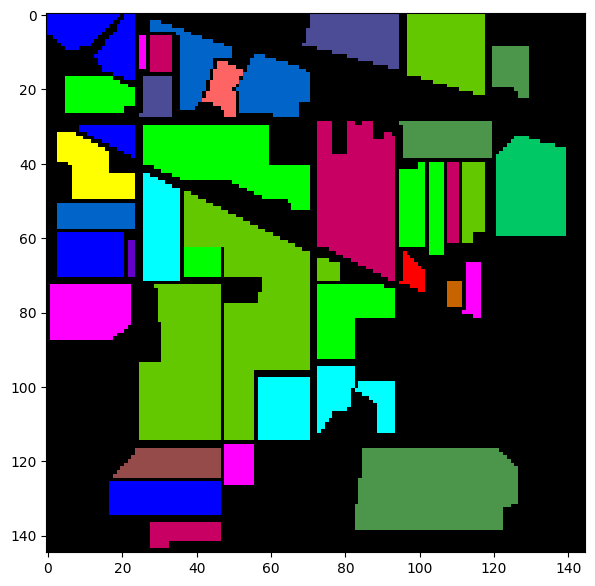

In [52]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

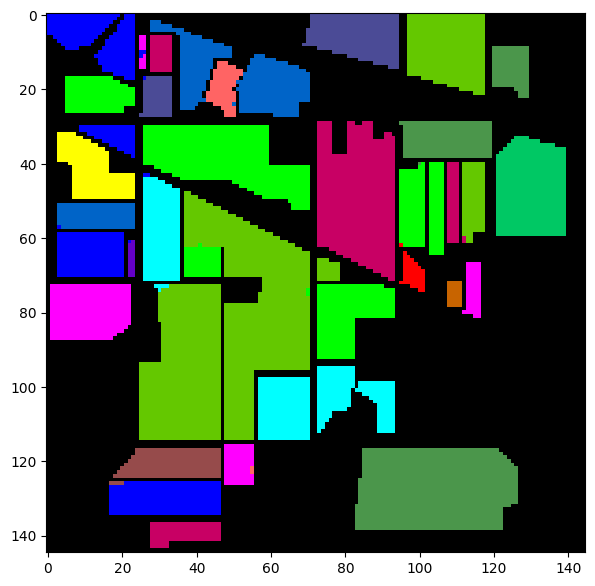

In [53]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [54]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)